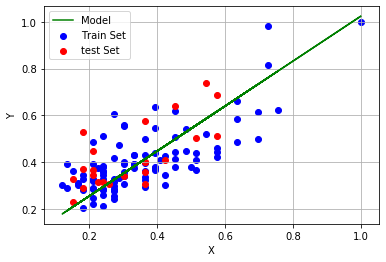

Iteration: 2500 - Error: 0.0114


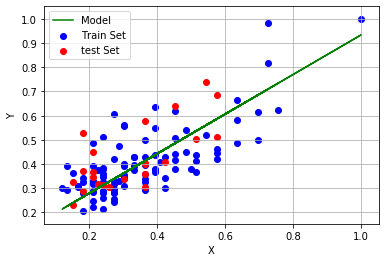

Iteration: 5000 - Error: 0.0095


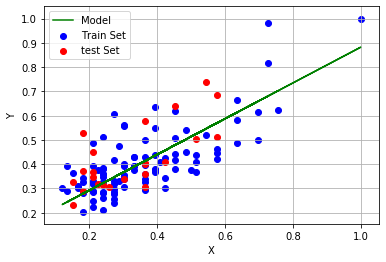

Iteration: 7500 - Error: 0.0089


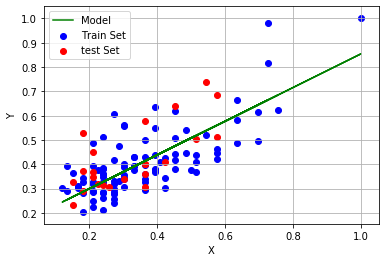

Iteration: 10000 - Error: 0.0087
수렴


In [1]:
#라이브러리 호출
import pandas as pd
import statsmodels.api as sm
import numpy as np
from pandas import Series, DataFrame
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline


#주식데이터 크롤링
corp_code = '005930'
for page in range(1, 13):
    url_tmp = 'http://finance.naver.com/item/sise_day.nhn?code=%s&page=%s'
    url = url_tmp % (corp_code, page)
    html = requests.get(url).text
    html = html.replace('\n', '')
    html = html.replace('\t', '')
    html = html.replace(',', '')
    html = html.replace('.', '-')
    soup = BeautifulSoup(html, 'lxml')
    
    span_data = soup.find_all('span')
    td_data = soup.find_all('td')
    tr_data = soup.find_all('tr')
    th_data = soup.find_all('th')
    if page == 1:
        columns_list = []
        for i in range(len(th_data)):
            i_text = th_data[i].text
            columns_list.append(i_text)
        stock_price_all_array = np.array([columns_list])
    
    rest_page = 0 
    stock_price_list = [] 
    for i in range(1, len(span_data)): 
        a = span_data[i].text 
        stock_price_list.append(a) 
        if page > 1 and stock_price_list[0] == stock_price_all_array[-10,0]: 
            rest_page = (30 - page)*10 
            stock_price_array = np.zeros((rest_page,7)) 
            stock_price_all_array = np.append(stock_price_all_array, stock_price_array, axis=0) 
            break 
        if i % 7 == 0: 
            stock_price_array = np.array([stock_price_list]) 
            stock_price_all_array = np.append(stock_price_all_array, stock_price_array, axis=0) 
            stock_price_list = []    
    if rest_page: 
        break 
    elif len(span_data) < 70: 
        rest_row = int((70 - len(span_data))/7+1) 
        stock_price_array = np.zeros((rest_row, 7)) 
        stock_price_all_array = np.append(stock_price_all_array, stock_price_array, axis=0)   
         
        rest_page = (13 - page-1)*10 
        stock_price_array = np.zeros((rest_page,7)) 
        stock_price_all_array = np.append(stock_price_all_array, stock_price_array, axis=0) 
        break
    
stock_price_all_array = np.delete(stock_price_all_array, 0, 0)
stock_price_all_df = DataFrame(stock_price_all_array, columns=columns_list).set_index('날짜')
stock_price_all_df = stock_price_all_df.reset_index()


#금일 데이터 제거(아웃라이어)
stock_price_all_df=stock_price_all_df[1:].reset_index(drop=True)

#날짜를 제외한 다른 데이터를 수치(int or float) 타입으로 변환하기
stock_price_all_df.iloc[:, 1:6]= stock_price_all_df.iloc[:, 1:6].astype(float) 

#변동폭 계산하기
stock_price_all_df["변동폭"] = stock_price_all_df["고가"] - stock_price_all_df["저가"]

#정규화하기
data_x = stock_price_all_df["변동폭"].astype(float)/max(stock_price_all_df["변동폭"].astype(float))
data_y = stock_price_all_df["거래량"].astype(float)/max(stock_price_all_df["거래량"].astype(float))

#행렬타입으로 변환하기
data_x = np.array(data_x)[:, np.newaxis]
data_y = np.array(data_y)[:, np.newaxis]

#상수넣기
data_x = np.hstack((np.ones_like(data_x), data_x))

#데이터 셔플하고 훈련 테스트 데이터로 나누기
order = np.random.permutation(len(data_x))
portion = int(len(data_x)*(20/100))
test_x = data_x[order[:portion]]
test_y = data_y[order[:portion]]
train_x = data_x[order[portion:]]
train_y = data_y[order[portion:]]


#기울기 및 에러 계산하는 함수 정의
def get_gradient(w, x, y):

    y_estimate = x.dot(w)
    error = (y.flatten() - y_estimate)
    mse = (1.0 / len(x)) * np.sum(np.power(error, 2))    
    gradient = -(1.0 / len(x)) * error.dot(x)

    return gradient, mse



#회귀 신경망 수행
w = np.random.randn(2) #임의의 가중치 생성
alpha = 0.01  # 학습률
tolerance = 0.00001  #기준 에러 차이 설정

# 그라디언트 하강 수행
iterations = 1
while True:
    # 그라디언트만큼 감소시키고 추정파라미터 갱신
    gradient, error = get_gradient(w, train_x, train_y)
    new_w = w - alpha * gradient

    # 이전 예측 모델과 새로운 예측 모델의 차이가 매우 작으면 수렴으로 가정
    if np.sum(abs(new_w - w)) < tolerance:
        print("수렴")
        break
    # 반복 250회마다 오차와 현재 그래프 출력
    if iterations % 2500 == 0:
        plt.plot(data_x[:, 1], data_x.dot(w), c='g', label='Model')
        plt.scatter(train_x[:, 1], train_y, c='b', label='Train Set')
        plt.scatter(test_x[:, 1], test_y, c='r', label='test Set')
        plt.grid()
        plt.legend(loc='best')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()        
        print('Iteration: %d - Error: %.4f' % (iterations, error))
    iterations += 1
    w = new_w